# Heuristic Policy

In [118]:
import numpy as np
import gym
from helpers import *

np.random.seed(127)

In [119]:
env = NormalizedEnv(gym.make("Pendulum-v1"))

In [120]:
def run_episode(env, agent):
    state = env.reset()[0]
    trunc = False
    rewards = []
    while not trunc:
        action = agent.compute_action(state)
        state, reward, _, trunc, _ = env.step(action)
        rewards.append(reward)

    return rewards


In [121]:
rewards = run_episode(env, RandomAgent(env))
print("Total reward for a single episode with a random policy: ", np.sum(rewards))

Total reward for a single episode with a random policy:  -1168.1055308691602


/Users/tudoroancea/miniforge3/envs/cs_456_project/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [122]:
mean_reward = np.mean([np.sum(run_episode(env, RandomAgent(env))) for _ in range(100)])
print("Mean reward over 100 episoded with a random policy: ", mean_reward)

Mean reward over 100 episoded with a random policy:  -1229.957298298861


In [123]:
class HeuristicPendulumAgent:
    def __init__(self, torque1, torque2):
        self.torque1 = torque1
        self.torque2 = torque2

    def compute_action(self, state):
        angle = np.arctan2(state[0], state[1])
        # return (
        #     self.torque1 * np.sign(state[2])
        #     if angle < 0
        #     else -self.torque2 * np.sign(state[2])
        # )
        # vectorized way:
        return np.where(angle < 0, self.torque1 * np.sign(state[2]), -self.torque2 * np.sign(state[2]))


agent = HeuristicPendulumAgent(0.25, 0.25)
mean_reward = np.mean([np.sum(run_episode(env, agent)) for _ in range(100)])
print("Mean reward over 100 episodes with heursitic policy: ", mean_reward)

Mean reward over 100 episodes with heursitic policy:  -849.3335585879889


# Q-function of the heuristic policy

In [124]:
from collections import deque

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [144]:
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        self.buffer = deque(maxlen=capacity)

    def __len__(self) -> None:
        return len(self.buffer)

    def append(self, state, action, reward, next_state, trunc) -> None:
        self.buffer.append((state, action, reward, next_state, trunc))

    def sample(self, batch_size: int):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, truncs = zip(
            *(self.buffer[idx] for idx in indices)
        )

        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(truncs, dtype=bool),
        )

In [145]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        return self.net(x)

In [146]:
def train_qnetwork(
    env,
    agent,
    qnetwork,
    batch_size=128,
    buffer_size=1e4,
    gamma=0.99,
    learning_rate=1e-4,
):
    buffer = ReplayBuffer(int(buffer_size))
    criterion = nn.MSELoss()
    optimizer = optim.SGD(qnetwork.parameters(), lr=learning_rate)

    losses = []
    for episode in tqdm.trange(1000):
        state = env.reset()[0]
        trunc = False
        while not trunc:
            action = agent.compute_action(state)
            next_state, reward, _, trunc, _ = env.step(action)
            buffer.append(state, action, reward, next_state, trunc)
            state = next_state

        if len(buffer) < batch_size:
            continue
        
        states, actions, rewards, next_states, truncs = buffer.sample(batch_size)
        q_values = qnetwork(
            torch.from_numpy(np.hstack((states, actions.reshape(-1, 1)))).float()
        ).squeeze()
        next_actions = agent.compute_action(next_states.T).reshape(-1, 1)
        next_q_values = qnetwork(
            torch.from_numpy(np.hstack((next_states, next_actions))).float()
        ).squeeze()
        target = (
            torch.from_numpy(rewards).float()
            + gamma * next_q_values * ~torch.from_numpy(truncs).bool()
        )
        loss = criterion(q_values, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses

In [156]:
class EpsilonPolicyWrapper:
    def __init__(self, policy, epsilon):
        self.policy = policy
        self.epsilon = epsilon

    def compute_action(self, state):
        if np.random.rand() < self.epsilon:
            return (
                np.random.uniform(-1, 1)
                if len(state.shape) == 1
                else np.random.uniform(-1, 1, size=state.shape[1])
            )
        else:
            return self.policy.compute_action(state)

100%|██████████| 1000/1000 [00:10<00:00, 94.09it/s]


Text(0.5, 1.0, 'Losses')

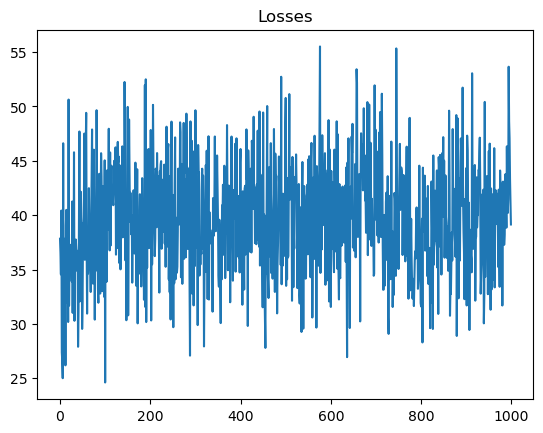

In [158]:
qnetwork = QNetwork()
losses = train_qnetwork(
    env,
    EpsilonPolicyWrapper(HeuristicPendulumAgent(0.25, 0.25), 0.1),
    qnetwork,
    learning_rate=1e-4,
)
plt.plot(losses)
plt.title("Losses")

In [179]:
def polar_heatmap(qnetwork, velocity, torque):
    """
    Plots a polar heatmap with matplotlib where the angle corresponds to the angle of 
    the pandulum and the color corrsponds to the magnitude of the Q values. 
    Radii should be ignore and patches should be created for each angle.
    """
    angles = np.linspace(-np.pi, np.pi, 100)
    q_values = []
    for angle in angles:
        state_action_pair = np.array([np.cos(angle), np.sin(angle), velocity, torque])
        q_values.append(qnetwork(torch.from_numpy(state_action_pair).float()).item())
    
    plt.subplot(projection="polar")
    r, th = np.meshgrid(np.array([0, 1]), angles)
    plt.pcolormesh(th, r, np.array(q_values).reshape(-1,1), shading="nearest")
    plt.colorbar()
    plt.show()

TypeError: Dimensions of C (100, 1) are incompatible with X (2) and/or Y (100); see help(pcolormesh)

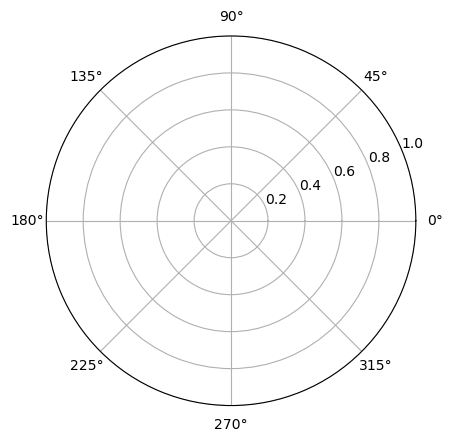

In [180]:
polar_heatmap(qnetwork, 0, 0.25)